# Business Understanding

## Background

text

### Features

- **Net Downward Shortwave Radiation Flux [W/m^2]:** 
- **Wind Gust Surface [m/s]:** 
- **Planetary Boundary Layer Height [m]:** 
- **Mean Sea Level Pressure [pa]:** 
- **Potential Temperature Difference between 80m and 0m [K]:**
- **Specific Humidity in 2m height [1]:** 
- **Specific Humidity Mean over first 30 hPa (~250m) [1]:** 
- **Relative Humidity in 925 hPa pressure level [%]:** 
- **Relative Humidity in 950 hPa pressure level [%]:**
- **Net Sensible Heat Flux (conductive heat flux of the Earth surface to the atmosphere) [W/m^2]:**
- **Temperature in 100m height [K]:** 
- **Temperature in 2m height [K]:** 
- **Temperature Mean over first 30 hPa (~250m) [K]:** 
- **Total Cloud Cover, low level clouds (0km - 2km height) [%]:** 
- **Total Cloud Cover, mid level clouds (2km - 7km height) [%]:** 
- **Wind Direction in 100 m height [°]:** 
- **Wind Direction in 10 m height [°]:** 
- **Wind Direction Mean over first 30 hPa (~250m) [°]:** 
- **Wind Direction in 925 hPa pressure level [°]:** 
- **Wind Speed in 100 m height [m/s]:** 
- **Wind Speed in 10 m height [m/s]:** 
- **Wind Speed Mean over first 30 hPa (~250m) [°]:** 
- **Wind Speed in 925 hPa pressure level [°]:** 
- **Date and 24 Hours divided in quarters [?]:** 
- **Azimuth angle of the sun [°]:** 
- **Elevation angle of the sun [°]:** 

# Envoirment Set- Up

## Load relevant Python Packages

In [22]:
reset -fs

In [23]:
# Importing the most important modules and setting the style for following plots
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle


# For Data Mining
import os, glob

# For Data Cleaning
from datetime import datetime
import missingno as msno

from pandas import read_csv
from pandas import datetime

from matplotlib import pyplot
import matplotlib.dates as mdates

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

## Global Variables and Settings

In [25]:
# Setting the random seed for reproducability
%matplotlib inline
plt.style.use('seaborn')
sns.set(rc={'figure.figsize':(14,8)})
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
RSEED = 42

# Loading Datasets

## GFS Data

In [29]:
# reading in the feature dataframe
with open('./data/griddata_gfs_us_20180101_20190826_03_final.p', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    df_features = u.load()

In [30]:
print(df_features.shape)
df_features.head(2)

(14378, 26)


,dswrf_sfc_wm2,gust_sfc_ms,hpbl_sfc_m,msl_ms_pa,pottemp_80mto0m_K,q_2m_1,q_pfg30_1,r_pl925_%,r_pl950_%,shtfl_sfc_wm2,t_100m_k,t_2m_k,t_pfg30_k,tcclow_sfc_%,tccmedium_sfc_%,wdir_100m_dn,wdir_10m_dn,wdir_pfg30_dn,wdir_pl925_dn,wsp_100m_ms,wsp_10m_ms,wsp_pfg30_ms,wsp_pl925_ms,created_on,azimuth,elevation
index,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-01 06:00:00+00:00,0.0,16.777032,1349.927656,99212.0625,0.559356,0.005105,0.004852,89.975,83.075,-58.444885,280.079346,280.496348,279.811816,99.375,49.50,54.455224,51.936818,54.855777,58.963042,16.548291,9.772748,16.622077,21.963719,2018-01-01 00:00:00+00:00,111.880959,-12.132894
2018-01-01 07:00:00+00:00,0.0,16.606744,1352.623506,99259.8125,0.528755,0.005005,0.004739,89.250,82.250,-59.127808,279.950000,280.339922,279.664160,99.250,79.25,62.428351,59.839207,62.809819,66.607932,16.795002,9.966123,16.832585,21.917341,2018-01-01 00:00:00+00:00,122.901711,-3.799353


In [32]:
df_features.tail(2)

,dswrf_sfc_wm2,gust_sfc_ms,hpbl_sfc_m,msl_ms_pa,pottemp_80mto0m_K,q_2m_1,q_pfg30_1,r_pl925_%,r_pl950_%,shtfl_sfc_wm2,t_100m_k,t_2m_k,t_pfg30_k,tcclow_sfc_%,tccmedium_sfc_%,wdir_100m_dn,wdir_10m_dn,wdir_pfg30_dn,wdir_pl925_dn,wsp_100m_ms,wsp_10m_ms,wsp_pfg30_ms,wsp_pl925_ms,created_on,azimuth,elevation
index,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-08-26 17:00:00+00:00,217.0,6.996934,294.434175,101819.59375,0.721496,0.01328,0.011999,66.625,64.775,-17.322095,297.00,297.050024,297.0,0.0,0.0,253.352783,249.491241,254.108723,307.177015,6.489624,3.745793,6.426924,5.507465,2019-08-23 18:00:00+00:00,272.617737,12.060012
2019-08-26 18:00:00+00:00,79.5,8.050885,215.534009,101816.78750,1.798953,0.01272,0.011877,66.800,64.175,-38.183350,296.25,294.969312,296.0,0.0,0.0,250.512384,244.554716,251.835064,308.818931,7.496367,3.839874,7.413974,5.639764,2019-08-23 18:00:00+00:00,284.064789,2.764322


In [148]:
# rename columns which contains symbols
df_features = df_features.rename(columns={'r_pl925_%': 'r_pl925_perc','r_pl950_%': 'r_pl950_perc',
                        'tcclow_sfc_%': 'tcclow_sfc_perc','tccmedium_sfc_%': 'tccmedium_sfc_perc'})

## Quadra Data

In [28]:
# reading in the target dataframe
with open('./data/obs_20180101_20190625_03_final_normed.p', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    df_target = u.load()

In [150]:
print(df_target.shape)
df_target.head()

(70710, 3)


,power_mw_obsnorm,power_available_mw_obsnorm,target_losses_norm
2018-01-01 00:00:00+01:00,0.330269,0.450934,0.120665
2018-01-01 00:10:00+01:00,0.339204,0.457539,0.118335
2018-01-01 00:20:00+01:00,0.336993,0.456577,0.119584
2018-01-01 00:30:00+01:00,0.337858,0.462447,0.124589
2018-01-01 00:40:00+01:00,0.353646,0.483538,0.129892


In [151]:
df_target.tail()

,power_mw_obsnorm,power_available_mw_obsnorm,target_losses_norm
2019-06-25 01:10:00+02:00,0.290788,0.317405,0.026618
2019-06-25 01:20:00+02:00,0.297746,0.330850,0.033104
2019-06-25 01:30:00+02:00,0.310582,0.341660,0.031078
2019-06-25 01:40:00+02:00,0.308457,0.338645,0.030189
2019-06-25 01:50:00+02:00,0.309148,0.339853,0.030705


The feature data is available for a hourly frequency and the target data for a 10minute frequency.
The feature data is available from 1st Aug 0:00 up to the 26th Aug 2019 and the target data from 1st Aug 06:00 up to the 25th Jun 2019.
Moreover, the timezone in the datasets is inconsistent.

We will need to create consistency in these indices, which will be done in the following.

In [152]:
# converting to same timezone
df_features.index = df_features.index.tz_localize(None).to_series(keep_tz=True)

In [153]:
df_features.head()

,dswrf_sfc_wm2,gust_sfc_ms,hpbl_sfc_m,msl_ms_pa,pottemp_80mto0m_K,q_2m_1,q_pfg30_1,r_pl925_perc,r_pl950_perc,shtfl_sfc_wm2,t_100m_k,t_2m_k,t_pfg30_k,tcclow_sfc_perc,tccmedium_sfc_perc,wdir_100m_dn,wdir_10m_dn,wdir_pfg30_dn,wdir_pl925_dn,wsp_100m_ms,wsp_10m_ms,wsp_pfg30_ms,wsp_pl925_ms,created_on,azimuth,elevation
index,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-01 06:00:00,0.0,16.777032,1349.927656,99212.0625,0.559356,0.005105,0.004852,89.975,83.075,-58.444885,280.079346,280.496348,279.811816,99.375,49.500,54.455224,51.936818,54.855777,58.963042,16.548291,9.772748,16.622077,21.963719,2018-01-01 00:00:00+00:00,111.880959,-12.132894
2018-01-01 07:00:00,0.0,16.606744,1352.623506,99259.8125,0.528755,0.005005,0.004739,89.250,82.250,-59.127808,279.950000,280.339922,279.664160,99.250,79.250,62.428351,59.839207,62.809819,66.607932,16.795002,9.966123,16.832585,21.917341,2018-01-01 00:00:00+00:00,122.901711,-3.799353
2018-01-01 08:00:00,0.0,16.750567,1385.881213,99340.0125,0.519516,0.004875,0.004601,88.350,81.475,-60.174194,279.675000,280.099258,279.425000,96.375,71.125,69.380999,66.846392,69.702886,73.395684,17.187174,10.191553,17.103298,22.151705,2018-01-01 00:00:00+00:00,134.513901,3.528108
2018-01-01 09:00:00,30.0,16.653720,1406.317913,99435.6875,0.462775,0.004693,0.004395,85.400,78.575,-61.376221,279.525000,279.992949,279.400000,69.250,34.750,71.932504,69.538877,72.116654,75.992542,16.804585,10.074198,16.507619,21.857454,2018-01-01 00:00:00+00:00,146.969666,9.473817
2018-01-01 10:00:00,70.0,16.143047,1413.328074,99523.6750,0.395166,0.004618,0.004322,85.275,78.300,-50.711792,279.388184,279.973125,279.325000,56.250,8.625,69.634668,67.391618,69.753380,73.848494,15.970588,9.719457,15.561127,21.082533,2018-01-01 00:00:00+00:00,160.319397,13.648098


In [154]:
# resampling to a time range of 10 minutes and interpolate between the hourly values
df_features = df_features.resample('10min', axis='index').interpolate()
df_features = df_features.fillna(method='ffill')

In [155]:
df_features.head()

,dswrf_sfc_wm2,gust_sfc_ms,hpbl_sfc_m,msl_ms_pa,pottemp_80mto0m_K,q_2m_1,q_pfg30_1,r_pl925_perc,r_pl950_perc,shtfl_sfc_wm2,t_100m_k,t_2m_k,t_pfg30_k,tcclow_sfc_perc,tccmedium_sfc_perc,wdir_100m_dn,wdir_10m_dn,wdir_pfg30_dn,wdir_pl925_dn,wsp_100m_ms,wsp_10m_ms,wsp_pfg30_ms,wsp_pl925_ms,created_on,azimuth,elevation
index,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-01 06:00:00,0.0,16.777032,1349.927656,99212.062500,0.559356,0.005105,0.004852,89.975000,83.0750,-58.444885,280.079346,280.496348,279.811816,99.375000,49.500000,54.455224,51.936818,54.855777,58.963042,16.548291,9.772748,16.622077,21.963719,2018-01-01 00:00:00+00:00,111.880959,-12.132894
2018-01-01 06:10:00,0.0,16.748651,1350.376965,99220.020833,0.554256,0.005088,0.004833,89.854167,82.9375,-58.558706,280.057788,280.470277,279.787207,99.354167,54.458333,55.784078,53.253883,56.181451,60.237190,16.589409,9.804977,16.657162,21.955989,2018-01-01 00:00:00+00:00,113.717751,-10.743970
2018-01-01 06:20:00,0.0,16.720270,1350.826273,99227.979167,0.549156,0.005072,0.004815,89.733333,82.8000,-58.672526,280.036230,280.444206,279.762598,99.333333,59.416667,57.112933,54.570948,57.507124,61.511338,16.630528,9.837206,16.692246,21.948260,2018-01-01 00:00:00+00:00,115.554543,-9.355046
2018-01-01 06:30:00,0.0,16.691888,1351.275581,99235.937500,0.544055,0.005055,0.004796,89.612500,82.6625,-58.786346,280.014673,280.418135,279.737988,99.312500,64.375000,58.441787,55.888013,58.832798,62.785487,16.671646,9.869435,16.727331,21.940530,2018-01-01 00:00:00+00:00,117.391335,-7.966123
2018-01-01 06:40:00,0.0,16.663507,1351.724889,99243.895833,0.538955,0.005038,0.004777,89.491667,82.5250,-58.900167,279.993115,280.392064,279.713379,99.291667,69.333333,59.770642,57.205077,60.158471,64.059635,16.712765,9.901665,16.762416,21.932800,2018-01-01 00:00:00+00:00,119.228127,-6.577199


In [156]:
# converting to target data to the same timezone as the feature dataframe
df_target.index = df_target.index.tz_localize(None).to_series(keep_tz=True)

In [157]:
df_target.head()

,power_mw_obsnorm,power_available_mw_obsnorm,target_losses_norm
2018-01-01 00:00:00,0.330269,0.450934,0.120665
2018-01-01 00:10:00,0.339204,0.457539,0.118335
2018-01-01 00:20:00,0.336993,0.456577,0.119584
2018-01-01 00:30:00,0.337858,0.462447,0.124589
2018-01-01 00:40:00,0.353646,0.483538,0.129892


In [158]:
# combining both dataframes to have one to work in
df = pd.concat([df_target,df_features], axis=1)
df.iloc[35:38,:]

,power_mw_obsnorm,power_available_mw_obsnorm,target_losses_norm,dswrf_sfc_wm2,gust_sfc_ms,hpbl_sfc_m,msl_ms_pa,pottemp_80mto0m_K,q_2m_1,q_pfg30_1,r_pl925_perc,r_pl950_perc,shtfl_sfc_wm2,t_100m_k,t_2m_k,t_pfg30_k,tcclow_sfc_perc,tccmedium_sfc_perc,wdir_100m_dn,wdir_10m_dn,wdir_pfg30_dn,wdir_pl925_dn,wsp_100m_ms,wsp_10m_ms,wsp_pfg30_ms,wsp_pl925_ms,created_on,azimuth,elevation
2018-01-01 05:50:00,0.364547,0.891657,0.527110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
2018-01-01 06:00:00,0.486251,0.911849,0.425598,0.0,16.777032,1349.927656,99212.062500,0.559356,0.005105,0.004852,89.975000,83.0750,-58.444885,280.079346,280.496348,279.811816,99.375000,49.500000,54.455224,51.936818,54.855777,58.963042,16.548291,9.772748,16.622077,21.963719,2018-01-01 00:00:00+00:00,111.880959,-12.132894
2018-01-01 06:10:00,0.528225,0.932739,0.404513,0.0,16.748651,1350.376965,99220.020833,0.554256,0.005088,0.004833,89.854167,82.9375,-58.558706,280.057788,280.470277,279.787207,99.354167,54.458333,55.784078,53.253883,56.181451,60.237190,16.589409,9.804977,16.657162,21.955989,2018-01-01 00:00:00+00:00,113.717751,-10.743970


## Continuity Check

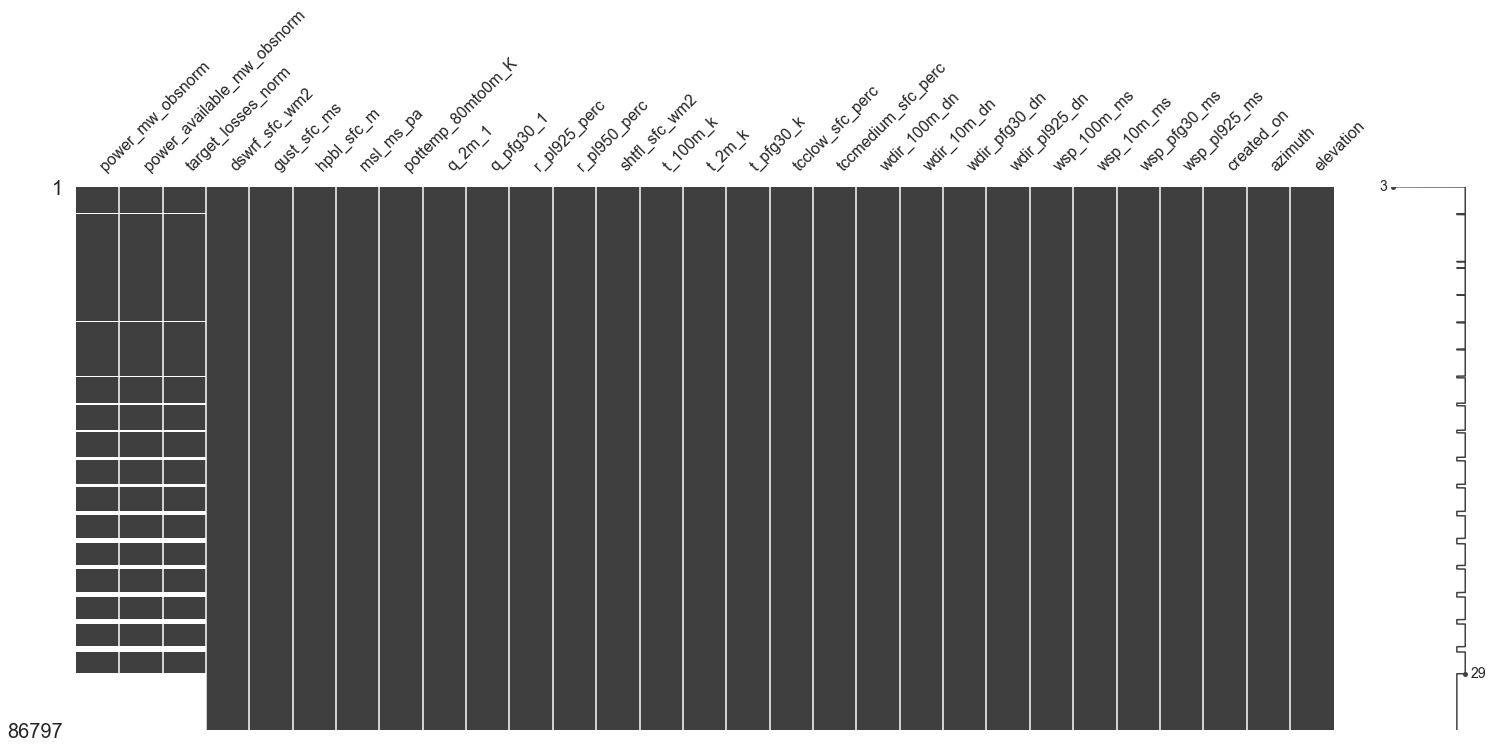

In [159]:
msno.matrix(df);

Step 1: Cutting both dataframes to same timespan

In [160]:
end_index_str = "2019-06-25 01:50:00"
end_index = pd.to_datetime(end_index_str)
end_index

Timestamp('2019-06-25 01:50:00')

In [161]:
df = df[df.index <= end_index]
df.tail()

,power_mw_obsnorm,power_available_mw_obsnorm,target_losses_norm,dswrf_sfc_wm2,gust_sfc_ms,hpbl_sfc_m,msl_ms_pa,pottemp_80mto0m_K,q_2m_1,q_pfg30_1,r_pl925_perc,r_pl950_perc,shtfl_sfc_wm2,t_100m_k,t_2m_k,t_pfg30_k,tcclow_sfc_perc,tccmedium_sfc_perc,wdir_100m_dn,wdir_10m_dn,wdir_pfg30_dn,wdir_pl925_dn,wsp_100m_ms,wsp_10m_ms,wsp_pfg30_ms,wsp_pl925_ms,created_on,azimuth,elevation
2019-06-25 01:10:00,0.290788,0.317405,0.026618,0.0,10.359493,243.857254,102171.072917,2.345096,0.009911,0.009590,50.9625,47.283333,-52.447021,291.874052,290.106441,291.924272,0.0,0.0,306.951150,296.702717,309.421430,343.567564,8.744555,4.072132,8.883419,9.956735,2019-06-24 18:00:00+00:00,25.039539,-11.744265
2019-06-25 01:20:00,0.297746,0.330850,0.033104,0.0,10.198118,237.270356,102161.183333,2.351379,0.009859,0.009548,50.4000,46.866667,-51.663354,291.798104,290.012882,291.869417,0.0,0.0,306.845568,296.363012,309.418563,343.433284,8.710395,4.049734,8.842701,9.802114,2019-06-24 18:00:00+00:00,27.223625,-10.975300
2019-06-25 01:30:00,0.310582,0.341660,0.031078,0.0,10.036744,230.683457,102151.293750,2.357663,0.009808,0.009506,49.8375,46.450000,-50.879688,291.722156,289.919324,291.814563,0.0,0.0,306.739985,296.023308,309.415695,343.299005,8.676235,4.027335,8.801982,9.647494,2019-06-24 18:00:00+00:00,29.407711,-10.206336
2019-06-25 01:40:00,0.308457,0.338645,0.030189,0.0,9.875370,224.096558,102141.404167,2.363946,0.009756,0.009464,49.2750,46.033333,-50.096021,291.646208,289.825765,291.759709,0.0,0.0,306.634403,295.683603,309.412828,343.164726,8.642075,4.004936,8.761264,9.492873,2019-06-24 18:00:00+00:00,31.591799,-9.437372
2019-06-25 01:50:00,0.309148,0.339853,0.030705,0.0,9.713995,217.509660,102131.514583,2.370229,0.009704,0.009422,48.7125,45.616667,-49.312354,291.570260,289.732206,291.704854,0.0,0.0,306.528820,295.343899,309.409961,343.030446,8.607915,3.982537,8.720545,9.338253,2019-06-24 18:00:00+00:00,33.775887,-8.668407


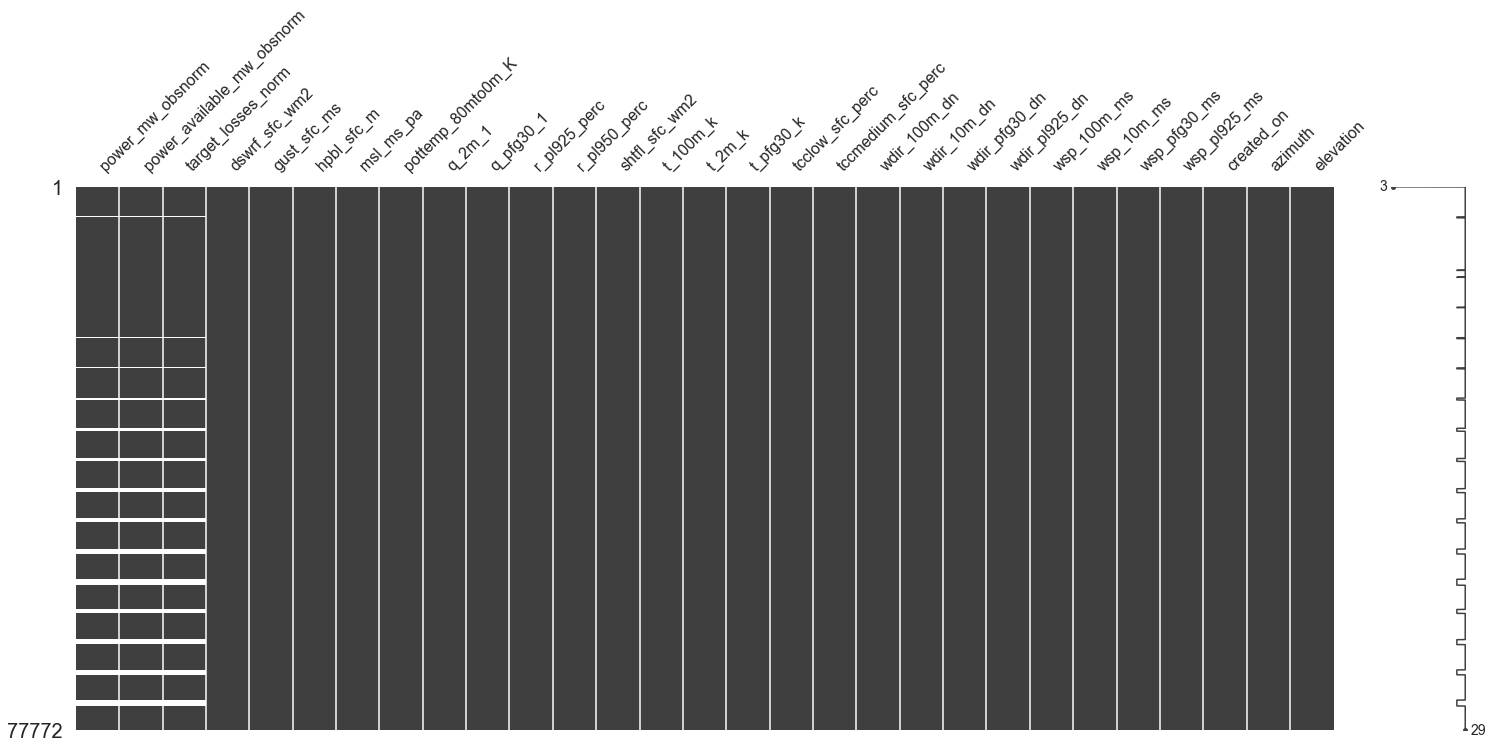

In [162]:
msno.matrix(df);

In [163]:
# Check for NaN values
missing = pd.DataFrame(df.isnull().sum(),columns=['Number'])
missing['Percentage'] = round(missing.Number/df.shape[0]*100,1)
missing[missing.Number!=0]

,Number,Percentage
power_mw_obsnorm,7062,9.1
power_available_mw_obsnorm,7062,9.1
target_losses_norm,7062,9.1
dswrf_sfc_wm2,36,0.0
gust_sfc_ms,36,0.0
hpbl_sfc_m,36,0.0
msl_ms_pa,36,0.0
pottemp_80mto0m_K,36,0.0
q_2m_1,36,0.0
q_pfg30_1,36,0.0


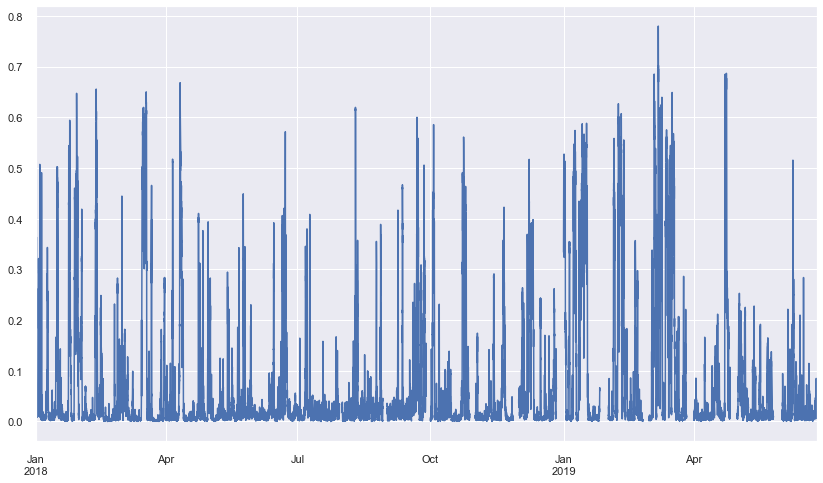

In [164]:
df.target_losses_norm.plot();

In [165]:
weekdays = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3: 'Thursday', 4: 'Friday', 5:'Saturday', 6:'Sunday'}

df['index1'] = df.index
df['Date'] = pd.to_datetime(df.index1.dt.date)
df['year'] = df.index1.dt.year
df['month'] = df.index1.dt.month
df['day'] = df.index1.dt.day
df['hour'] = df.index1.dt.hour
df['minute'] = df.index1.dt.minute
df['hour_minute'] = df['hour']+ (df['minute']//10 * 1/6)

df.drop(columns = ["index1"], inplace = True)
df.head(5)

,power_mw_obsnorm,power_available_mw_obsnorm,target_losses_norm,dswrf_sfc_wm2,gust_sfc_ms,hpbl_sfc_m,msl_ms_pa,pottemp_80mto0m_K,q_2m_1,q_pfg30_1,r_pl925_perc,r_pl950_perc,shtfl_sfc_wm2,t_100m_k,t_2m_k,t_pfg30_k,tcclow_sfc_perc,tccmedium_sfc_perc,wdir_100m_dn,wdir_10m_dn,wdir_pfg30_dn,wdir_pl925_dn,wsp_100m_ms,wsp_10m_ms,wsp_pfg30_ms,wsp_pl925_ms,created_on,azimuth,elevation,Date,year,month,day,hour,minute,hour_minute
2018-01-01 00:00:00,0.330269,0.450934,0.120665,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,2018-01-01,2018,1,1,0,0,0.000000
2018-01-01 00:10:00,0.339204,0.457539,0.118335,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,2018-01-01,2018,1,1,0,10,0.166667
2018-01-01 00:20:00,0.336993,0.456577,0.119584,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,2018-01-01,2018,1,1,0,20,0.333333
2018-01-01 00:30:00,0.337858,0.462447,0.124589,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,2018-01-01,2018,1,1,0,30,0.500000
2018-01-01 00:40:00,0.353646,0.483538,0.129892,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,2018-01-01,2018,1,1,0,40,0.666667


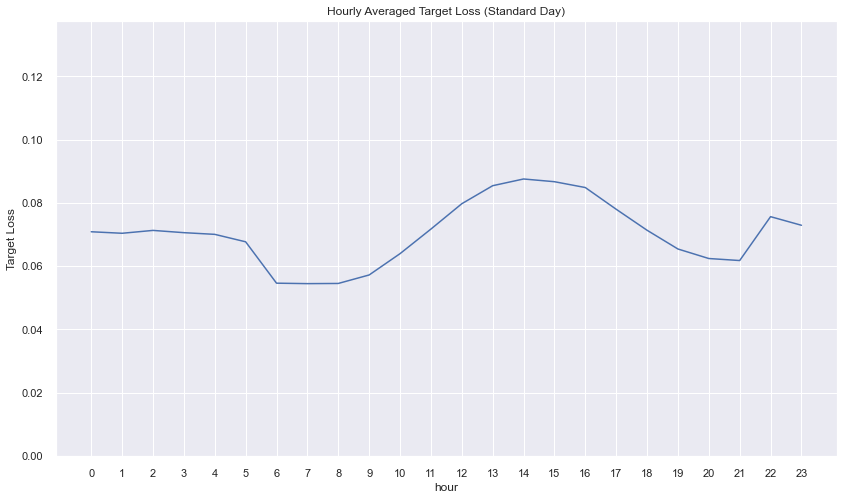

In [166]:
#Plotting average hourly load profile observed over the entire period 
df.groupby('hour')['target_losses_norm'].mean().plot(figsize = (14,8))
_ = plt.ylabel('Target Loss')
_ = plt.ylim([0, max(df.groupby('hour')['target_losses_norm'].mean()) + 0.05])
_ = plt.xticks(df['hour'].unique())
_ = plt.title('Hourly Averaged Target Loss (Standard Day)')

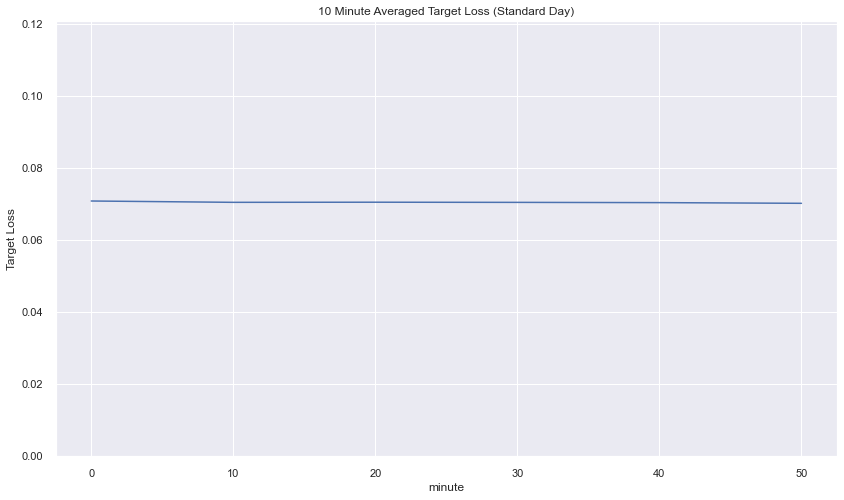

In [167]:
#Plotting 10 minute averaged target loss
df.groupby('minute')['target_losses_norm'].mean().plot(figsize = (14,8))
_ = plt.ylabel('Target Loss')
_ = plt.ylim([0, max(df.groupby('minute')['target_losses_norm'].mean()) + 0.05])
_ = plt.xticks(df['minute'].unique())
_ = plt.title('10 Minute Averaged Target Loss (Standard Day)')

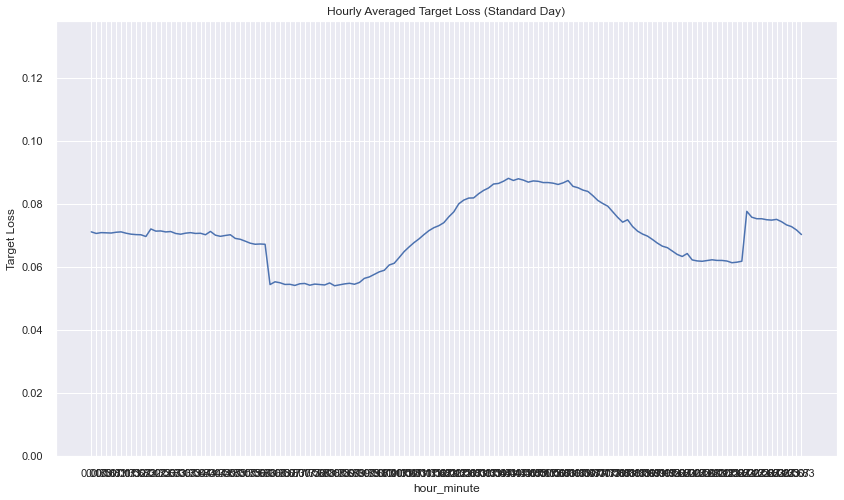

In [168]:
#Plotting average hourly load profile observed over the entire period 
hour_minute_means_loss = df.groupby('hour_minute')['target_losses_norm'].mean().reset_index()
hour_minute_means_available = df.groupby('hour_minute')['power_available_mw_obsnorm'].mean().reset_index()
hour_minute_means_cons = df.groupby('hour_minute')['power_mw_obsnorm'].mean().reset_index()
df.groupby('hour_minute')['target_losses_norm'].mean().plot(figsize = (14,8))
_ = plt.ylabel('Target Loss')
_ = plt.ylim([0, max(df.groupby('hour_minute')['target_losses_norm'].mean()) + 0.05])
_ = plt.xticks(df['hour_minute'].unique())
_ = plt.title('Hourly Averaged Target Loss (Standard Day)')

In [177]:
for row in df.iterrows():
    print(row)
    break


(Timestamp('2018-01-01 00:00:00', freq='10T'), power_mw_obsnorm                         0.330269
power_available_mw_obsnorm               0.450934
target_losses_norm                       0.120665
dswrf_sfc_wm2                                 NaN
gust_sfc_ms                                   NaN
hpbl_sfc_m                                    NaN
msl_ms_pa                                     NaN
pottemp_80mto0m_K                             NaN
q_2m_1                                        NaN
q_pfg30_1                                     NaN
r_pl925_perc                                  NaN
r_pl950_perc                                  NaN
shtfl_sfc_wm2                                 NaN
t_100m_k                                      NaN
t_2m_k                                        NaN
t_pfg30_k                                     NaN
tcclow_sfc_perc                               NaN
tccmedium_sfc_perc                            NaN
wdir_100m_dn                                  NaN
wdi

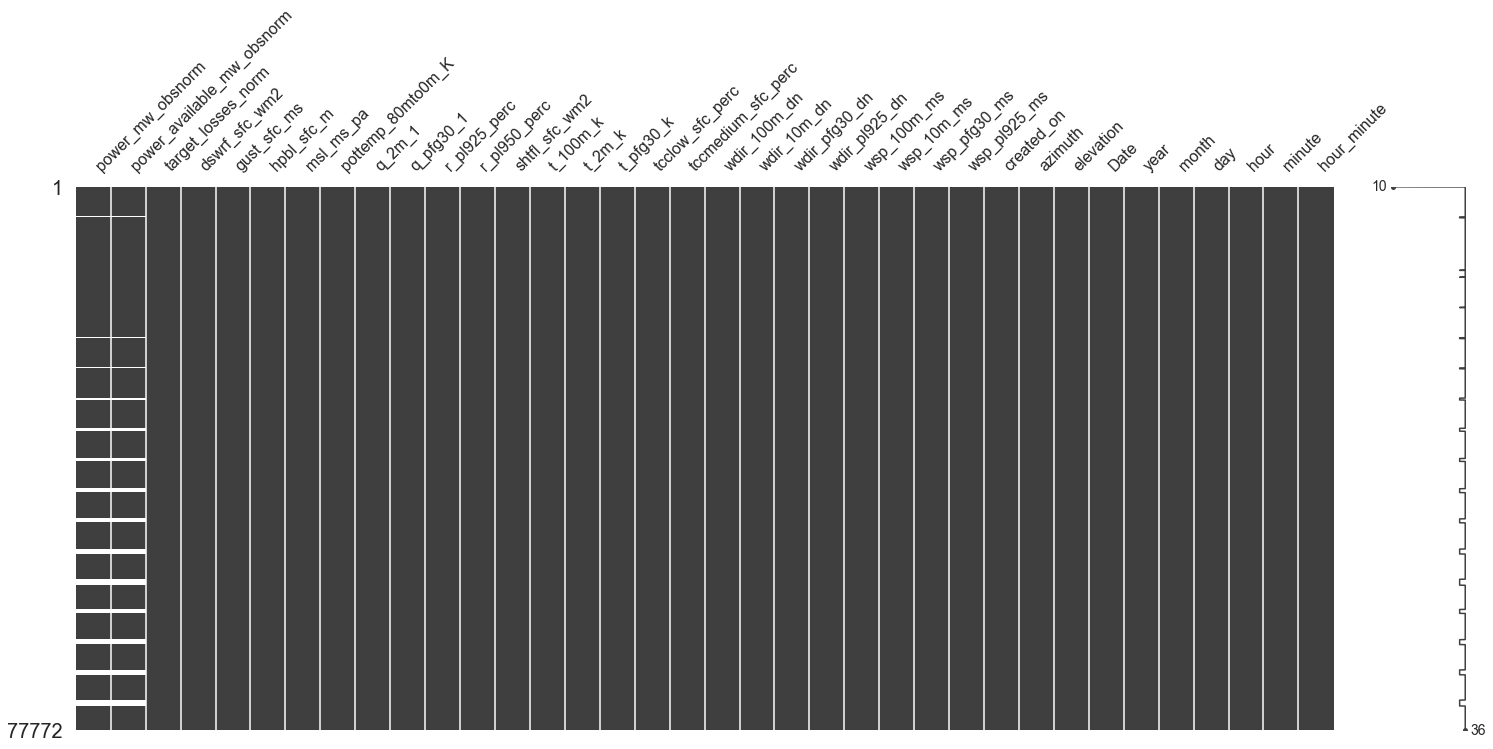

In [171]:
msno.matrix(df);

In [175]:
np.isnan(df['dswrf_sfc_wm2'].iloc[0])

True

In [174]:
df['target_losses_norm'].iloc[0]

0.12066465906646584

In [108]:
hour_minute_means_loss

,hour_minute,target_losses_norm
0,0.000000,0.071132
1,0.166667,0.070626
2,0.333333,0.070887
3,0.500000,0.070812
4,0.666667,0.070757
...,...,...
139,23.166667,0.074353
140,23.333333,0.073338
141,23.500000,0.072796
142,23.666667,0.071733
